# 3 Generate Predicted Data

This module is used for training the prediction model and generating prediction data.

After running notebooks 1 and 2, run all cells of this notebook to get the predicted dataset to "prediction.csv".
Creates also "midsummers_ts.csv" for visualizations.

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser
from datetime import datetime
from sklearn import model_selection, preprocessing, ensemble
%matplotlib inline

In [213]:
# data parameters
categorical_columns = ["vehicle_type", "location_id", "direction", "weekday", "week"]
dependent_columns = ["hour_{}".format(n) for n in range(1,25)]

# functions
def to_train_format(raw_data):
    """
    Converts categorical fields to dummies (and normalizes the values).
    Returns a DataFrame.
    """
    data = raw_data
    for col in categorical_columns:
        dummies = pd.get_dummies(data[col], prefix=col)
        data = pd.concat([data, dummies], axis=1)
        data = data.drop([col], axis=1)
    return data

def train_test_split(data, test_size=0.10):
    """
    Splits the formatted data into train and test sets.
    Returns X and Y + associated test sets as DataFrames.
    """
    X = data.drop(dependent_columns, axis=1)
    Y = data[dependent_columns]
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_size)
    return X_train, X_test, Y_train, Y_test

def train(X_train, Y_train, model):
    """
    Fits the model to the train data.
    Modifies the model parameter.
    """
    model.fit(X_train, Y_train)
    model.features = X_train.columns
    model.targets = Y_train.columns

def evaluate(X_test, Y_test, model):
    """
    Returns the coefficient of determination R^2 of the prediction.
    """
    score = model.score(X_test, Y_test)
    return score

def predict(row, model):
    """
    Uses the trained model to predict with the given DataFrame.
    Returns a DataFrame including the predictions.
    """
    row_f = to_train_format(row)
    row_formatted = pd.DataFrame()
    for col in model.features:
        if col in row_f.columns:
            row_formatted[col] = row_f[col]
        else:
            row_formatted[col] = 0
    pred = pd.DataFrame(model.predict(row_formatted))
    pred.columns = model.targets
    return pred

def sample_prediction(sample_data, model):
    """
    Generates the prediction of a sample item.
    Returns a DataFrame containing the original and the 
    predicted values side-by-side.
    """
    sample = sample_data.sample(1)
    result = pd.concat([sample, predict(sample, model)]).fillna("").transpose()
    index = result.columns[0]
    result.columns = [index, "prediction"]
    return result

def generate_prediction_series(
        model,
        dates=["2018-06-21", "2018-06-22", "2018-06-23", "2018-06-24", "2018-06-25", "2018-06-26"], 
        location_ids=[168, 1403, 110],
        vehicle_types=["13 Linja-autot", "12 KAIP", "11 HA-PA"],
    ):
    """
    Generates a predicted data series for the given dates, 
    locations, and vehicle types. Returns a DataFrame.
    """
    generated = pd.DataFrame()
    for date_str in dates:
        date = parser.parse(date_str)
        for location_id in location_ids:
            for vehicle_type in vehicle_types:
                for direction in [1,2]:
                    row = pd.DataFrame()
                    row["year"] = [date.year]
                    row["week"] = [date.isocalendar()[1]]
                    row["weekday"] = [date.weekday()]
                    row["location_id"] = [location_id]
                    row["direction"] = [direction]
                    row["vehicle_type"] = [vehicle_type]
                    #row["temperature"] = [15]
                    #row["rain"] = [0]
                    prediction = predict(row, model)
                    prediction.columns = dependent_columns
                    combined = pd.concat([row, prediction], axis=1)
                    generated = generated.append(combined, ignore_index=True)
    return generated

def get_location_name(location_id):
    """
    Returns the LAM station name of a location_id.
    """
    names = {168: "Askisto", 1403: "Kemijärvi", 110: "Mäntsälä"}
    return names[location_id]

def get_ts_row(data, location_id, year, week, weekday, hour):
    """
    Returns time series formatted row from the data. Includes only Cars & Vans, Trucs and Buses.
    """
    ts_row = pd.DataFrame()
    rows = data[(data.location_id == location_id) & (data.year == year) & (data.week == week) & (data.weekday == weekday)]
    cars_1 = rows[(rows.vehicle_type == "11 HA-PA") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    cars_2 = rows[(rows.vehicle_type == "11 HA-PA") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    trucks_1 = rows[(rows.vehicle_type == "12 KAIP") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    trucks_2 = rows[(rows.vehicle_type == "12 KAIP") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    buses_1 = rows[(rows.vehicle_type == "13 Linja-autot") & (rows.direction == 1)]["hour_{}".format(hour)].iloc[0]
    buses_2 = rows[(rows.vehicle_type == "13 Linja-autot") & (rows.direction == 2)]["hour_{}".format(hour)].iloc[0]
    date = datetime.strptime("{}-{}-{}".format(year, week, weekday+1), "%Y-%W-%u")
    ts_row["date"] = [date]
    ts_row["hour"] = "{:02}-{:02}".format(hour-1, hour)
    ts_row["LAM Station"] = [get_location_name(location_id)]
    ts_row["Cars and Vans - 1"] = cars_1
    ts_row["Cars and Vans - 2"] = cars_2
    ts_row["Trucks - 1"] = trucks_1
    ts_row["Trucks - 2"] = trucks_2
    ts_row["Buses - 1"] = buses_1
    ts_row["Buses - 2"] = buses_2
    return ts_row

def to_ts_format(data):
    """
    Converts the given dataset (of training or generating format) 
    to time series format. Returns a DataFrame.
    """
    ts_data = pd.DataFrame()
    for location_id in data.location_id.unique():
        for year in data[data.location_id == location_id].year.unique():
            for week in data[(data.location_id == location_id) & (data.year == year)].week.unique():
                for weekday in data[(data.location_id == location_id) & (data.year == year) & (data.week == week)].weekday.unique():
                    for hour in range(1,25):
                        try:
                            row = get_ts_row(data, location_id, year, week, weekday, hour)
                            ts_data = pd.concat([ts_data, row])
                        except:
                            print("Failed: ", location_id, year, week, weekday, hour)
    return ts_data.reset_index(drop=True)
    

In [156]:
# split the raw data to train and test sets
raw_data = pd.read_csv("refined_dataset.csv").sort_values(by="date")
raw_data = raw_data.drop(["sum", "location_name", "date"], axis=1)
model_data = raw_data
train_formatted_data = to_train_format(model_data)
X_train, X_test, Y_train, Y_test = train_test_split(train_formatted_data)

# random forest regression model
model = ensemble.RandomForestRegressor()

# train the model
train(X_train, Y_train, model)

# evaluate the model
evaluate(X_test, Y_test, model)

0.97359961870111988

In [199]:
# generate series over the prediction period and store as CSV
generated = to_ts_format(generate_prediction_series(model))
generated.to_csv("prediction.csv", index=False)

In [217]:
# create also ts formatted DataFrame from all midsummer weeks for the relevant vehicles 
midsummer_data = raw_data[(raw_data["vehicle_type"].isin(["13 Linja-autot", "12 KAIP", "11 HA-PA"])) & (raw_data.week == 25)]
midsummer_ts = to_ts_format(midsummer_data)
midsummer_ts.to_csv("midsummers_ts.csv")

Failed:  1403 2010 25 5 1
Failed:  1403 2010 25 5 2
Failed:  1403 2010 25 5 3
Failed:  1403 2010 25 5 4
Failed:  1403 2010 25 5 5
Failed:  1403 2010 25 5 6
Failed:  1403 2010 25 5 7
Failed:  1403 2010 25 5 8
Failed:  1403 2010 25 5 9
Failed:  1403 2010 25 5 10
Failed:  1403 2010 25 5 11
Failed:  1403 2010 25 5 12
Failed:  1403 2010 25 5 13
Failed:  1403 2010 25 5 14
Failed:  1403 2010 25 5 15
Failed:  1403 2010 25 5 16
Failed:  1403 2010 25 5 17
Failed:  1403 2010 25 5 18
Failed:  1403 2010 25 5 19
Failed:  1403 2010 25 5 20
Failed:  1403 2010 25 5 21
Failed:  1403 2010 25 5 22
Failed:  1403 2010 25 5 23
Failed:  1403 2010 25 5 24
Failed:  1403 2011 25 5 1
Failed:  1403 2011 25 5 2
Failed:  1403 2011 25 5 3
Failed:  1403 2011 25 5 4
Failed:  1403 2011 25 5 5
Failed:  1403 2011 25 5 6
Failed:  1403 2011 25 5 7
Failed:  1403 2011 25 5 8
Failed:  1403 2011 25 5 9
Failed:  1403 2011 25 5 10
Failed:  1403 2011 25 5 11
Failed:  1403 2011 25 5 12
Failed:  1403 2011 25 5 13
Failed:  1403 2011 

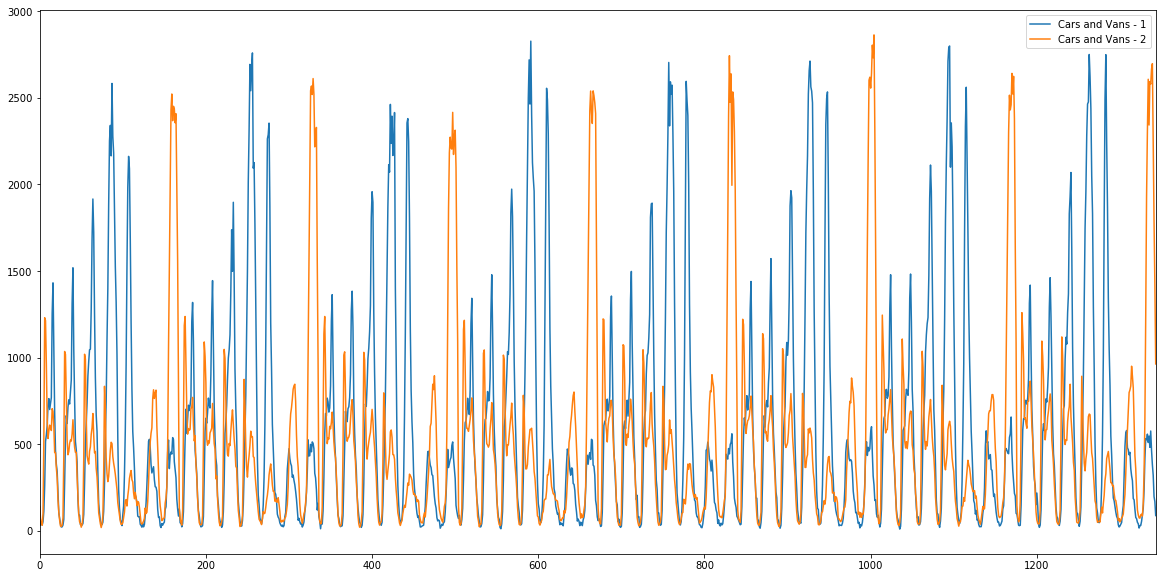

In [220]:
fig, ax = plt.subplots(figsize=(20, 10))
midsummer_ts[midsummer_ts["LAM Station"] == "Mäntsälä"][["date", "Cars and Vans - 1", "Cars and Vans - 2"]].plot(ax=ax)